# Kats 202 - Detection with Kats

This tutorial will introduce detection in Kats, including change point detection, outlier detection, and trend detection.  It is a more detailed and in-depth introduction than the one provided in Kats 101.  The table of contents for Kats 202 is as follows:

* 1. Changepoint Detection
    * 1.1 CUSUMDetector
    * 1.2 BOCPDetector
    * 1.3 RobustStatDetector
    * 1.4 Comparing the Changepoint Detectors
* 2. Outlier Detection
    * 2.1 OutlierDetector
    * 2.2 MultivariateAnomalyDetector
    * 2.3 HourlyRatioDetector
* 3. Trend Detection
    * 3.1 MKDetector

**Note:** We provide two types of tutorial notebooks

* **Kats 101**, basic data structure and functionalities in Kats    
* **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from imp import reload
from datetime import datetime, timedelta
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
reload(logging)

<module 'logging' from '/usr/local/Cellar/python@3.7/3.7.10_3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py'>

# 1. Changepoint Detection <a class="anchor" id="kats_basics"></a>

Changepoint detection tries to identify times when the probability distribution of a stochastic process or time series changes, e.g. the change of mean in a time series. It is one of the most popular detection tasks in time series analysis. 

## **1.1 `CUSUMDetector`**


CUSUM is a method to detect an up/down shift of means in a time series. Our implementation has two main steps:


1. **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point. The next changepoint is the location where the previous CUSUM time series is maximized (or minimized). This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.
2. **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1. The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  If we want to see all the changepoints, we can use the `return_all_changepoints` parameter in `CUSUMDetector` and set it to `True`.

Here are a few additional points worth mentioning:

* We assume there is at most one increase change point and at most one decrease change point. You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
* We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.


The full set of parameters for the `detector` method in `CUSUMDetector`, all of which are optional and have default values, are as follows: 
* **threshold**: float, significance level;
* **max_iter**: int, maximum iteration in finding the changepoint;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series;
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected;
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points;
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison;
* **magnitude_ratio**: float, comparable ratio;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones.

### Review Basic Usage

We begin by reviewing the basic usage of `CUSUMDetector` from the Kats 101 tutorial.  This simple example is the same one we first introduced there.

In [2]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector

# synthesize data with simulation
np.random.seed(10)
df_increase_decrease = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=60),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

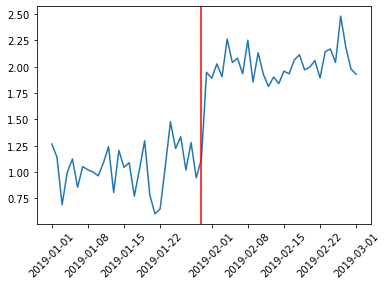

In [3]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=["increase"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

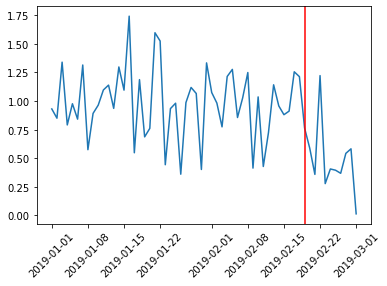

In [4]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','decrease']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=["decrease"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

### Interpret the result

If we do not specify which change directions we are looking for using the `change_directions` parameter, `CUSUMDetector` will look for both increases and decreases. In the case below where there is only an increase, it will detect that increase.

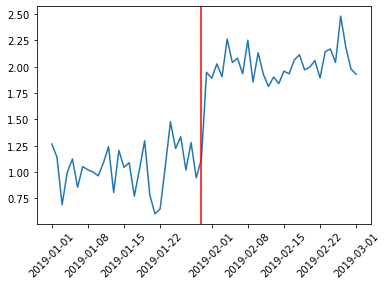

In [5]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector()

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

Let's take a look at how we can interpret the results of the `CUSUMDetector`.  The return type of the `detector` method is `List[Tuple[TimeSeriesChangePoint, CUSUMMetadata]]`. Most `detector` methods in Kats return this same structure, but each will have a different metadata object with metadata specific to that detector.

In [6]:
# Get the change point and metadata, since we only detected one change point 
# We can access it with change_points[0] because we only found one change point above
change_point, metadata = change_points[0]
change_point

TimeSeriesChangePoint(start_time: 2019-01-30 00:00:00, end_time: 2019-01-30 00:00:00, confidence: 1.0)

Now let's look at the metadata.  Here are the components of the metadata:
* **direction**: str, the change point direction, either 'increase' or 'decrease';
* **cp_index**: int, the index of the change point;
* **mu0**: float, mean before the change point;
* **mu1**: float, mean after the change point;
* **delta**: float, mu1 - mu0;
* **llr_int**: float, the log likelihood ratio in interest window, or `inf` if not using an interet window;
* **llr**: float, the log likelihood ratio for the full time series;
* **regression_detected**: bool, is the change point detected by the algorithm (only relevant when `return_all_changepoints=True`);
* **stable_changepoint**: bool, indicates whether the algorithm converged to this point (rather than hitting the iteration limit);
* **p_value**: float, p-value for the likelihood ratio test;
* **p_value_int**: float, p-value for the likelihood ratio test in interest_window, or `nan` if not using an interest window.

In [7]:
metadata.__dict__

{'_direction': 'increase',
 '_cp_index': 29,
 '_mu0': 1.0395982783530555,
 '_mu1': 2.0233303619383967,
 '_delta': 0.9837320835853411,
 '_llr_int': inf,
 '_llr': 128.93223399207324,
 '_regression_detected': True,
 '_stable_changepoint': True,
 '_p_value': 0.0,
 '_p_value_int': nan}

We will explain interest windows in the next section, but for now, notice that since we are not using the `interet_window` parameter in `CUSUMDetector`, the metadata values of `llr_int` and `p_value_int` are `inf` and `nan` respectively.  These values will be populated properly only when we use the `interet_window` parameter in `CUSUMDetector`.

### Interest Window & Daily Seasonality

Sometimes we want to look for a changepoint in a specific window, which we call an interest window and can be specified using the `interest_window` paramter in `CUSUMDetector`.  Here is what the detector essentially does when using an interest window:

1. Do both of the major aforementioned steps of CUSUM (locate the change point and test for signifiance) when only considering the data within the `interest_window`.  By default, continue only if we find a changepoint and reject the null hypothesis.
2. Do an additional test for statistical significance on the changepoint found in step 1 using the entire input time series (not just the restriction to `interest_window`).  By default, return this changepoint only if we reject the null hypothesis (unless we set the parameter `return_all_changepoints` to `True`).

Since the `CUSUMDetector` can only return one change point in each direction, we can use the `interest_window` parameter narrow the search window in the case that the input time series contains multiple change points.  However, the change point point we return must pass the likelihood ratio test for the entire time series (step 2 above) in addition to passing the likelihood ratio test within the interest window (step 1 above).

Let's return to the first example where we used `CUSUMDetector` to detect an increase.  If we set the `interest_window` to a window that contains the change point that we found above, we will find it again.

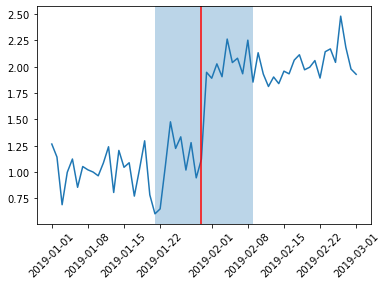

In [8]:
# limit the interest_window between 20th and 40th data point
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[20,40])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

If we set the `interest_window` to a window that does not find any change point, we will return no change point.

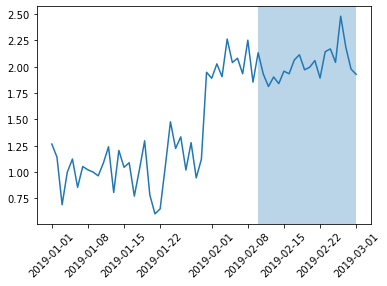

In [9]:
# limit the interest_window to last 20 the datapoint and no change point detected
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[40,60])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

If we are using an interest window in a time series with seasonality, we can get a false positive.  Here we show how this happens and how we can address the problem.  Let's start by generating a time series with seasonality.

In [10]:
# TODO: replace this code with import from test_detectors

# synthesize seasonal data with simulation
def simulate_seasonal_term(
    periodicity, total_cycles, noise_std=1.0, harmonics=None
):
    duration = periodicity * total_cycles
    assert duration == int(duration)
    duration = int(duration)
    harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

    lambda_p = 2 * np.pi / float(periodicity)

    gamma_jt = noise_std * np.random.randn((harmonics))
    gamma_star_jt = noise_std * np.random.randn((harmonics))

    total_timesteps = 100 * duration  # Pad for burn in
    series = np.zeros(total_timesteps)
    for t in range(total_timesteps):
        gamma_jtp1 = np.zeros_like(gamma_jt)
        gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
        for j in range(1, harmonics + 1):
            cos_j = np.cos(lambda_p * j)
            sin_j = np.sin(lambda_p * j)
            gamma_jtp1[j - 1] = (
                gamma_jt[j - 1] * cos_j
                + gamma_star_jt[j - 1] * sin_j
                + noise_std * np.random.randn()
            )
            gamma_star_jtp1[j - 1] = (
                -gamma_jt[j - 1] * sin_j
                + gamma_star_jt[j - 1] * cos_j
                + noise_std * np.random.randn()
            )
        series[t] = np.sum(gamma_jtp1)
        gamma_jt = gamma_jtp1
        gamma_star_jt = gamma_star_jtp1
    wanted_series = series[-duration:]  # Discard burn in

    return wanted_series

np.random.seed(1)
periodicity = 24
total_cycles = 3
harmonics = 2
noise_std = 3

seasonal_term = simulate_seasonal_term(
    periodicity, total_cycles, noise_std=noise_std, harmonics=harmonics
)
seasonal_term = seasonal_term / seasonal_term.std() * 2
residual = np.random.normal(0, 1, periodicity * total_cycles)
data = seasonal_term + residual
data -= np.min(data)

df_seasonality = pd.DataFrame(
    {
        "time": pd.date_range(
            "2020-01-01", periods=periodicity * total_cycles, freq="H"
        ),
        "seasonality": data,
    }
)
timeseries = TimeSeriesData(df_seasonality)
detector = CUSUMDetector(timeseries)

When we do detection using the interest window below, we get a false positive.  It is clear that the change point detected below is not a changepoint with respect to an entire series.  

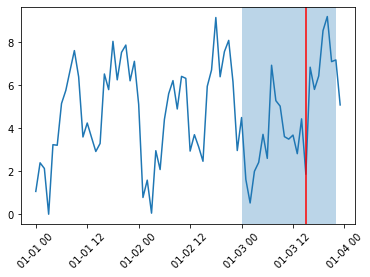

In [11]:
# Without magnitude comparison
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    change_directions=["increase"],
)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

We can mitigate false positives here by comparing the magnitude of the time series in the interest window to compare the magnitude of the time series in the interest window to the magnitude of the the time series prior to the interest window.  We need three additional parameters to do this: `magnitude_quantile`, `magnitude_comparable_day`, and `magnitude_ratio`.

Here is the procedure for using these parameters to restrict the number of false positives when detecting an increase (when looking for decreases, the time series values are multipled by -1 prior to using this procedure):

1) Calculate the `magnitude_quantile` percentile of the timeseries within the `interest_window`.  Call this value `p`    
2) Calculate the `magnitude_quantile` percentile over a sliding window of length equal to the length of `interest_window` in the time series prior to `interest_window`.  Count the proportion of intervals for which this percentile is smaller than `p / magnitude_ratio`.  Include this changepoint if and only if this proportion of days exceeds `magnitude_comparable_day`.

The values of `magnitude_comparable_day` and `magnitude_ratio` are 0.5 and 1.3 by default, and we only include them below for readability.    When the `magnitude_quantile` is not included as a paramter, we are not doing a magnitude ratio comparison.  Below we have `magnitude_quantile =1` which means the value of `p` in step 1 above is equal to the maximium value of the time series over the `interest_window`.  Then based on the parameters we are using, we will keep a changepoint detected in `interest_window` only if at least half of the intervals prior to `interest_window` with the same length as `interest_window` have a maximum value not exceeding `p/1.3`.

As we see below, adding this additional restriction on the change points we detect removes the false positive.

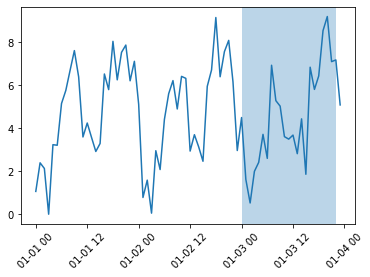

In [12]:
# With magnitude comparison, seasonal false positive not detected
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    magnitude_quantile=1, # enable magnitude comparison
    magnitude_comparable_day=0.5, # this is the default value
    magnitude_ratio=1.3, # this is the default value
    change_directions=["increase"],
)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

### Detecting multiple change points
In most use cases, there are more than one change point, and you might want to monitor the regressions continuously. Here shows how can we achieve detecting multiple change points over time.

In [21]:
# synthesize data with simulation
np.random.seed(10)
df_multi_cps = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=100),
        'y':np.concatenate([
            np.random.normal(1, 0.2, 30), 
            np.random.normal(2, 0.2, 30),
            np.random.normal(0, 0.2, 20),
            np.random.normal(3, 1, 20),
        ]),
    }
)
multi_cp_ts = TimeSeriesData(df_multi_cps)

Iterate through the time series using a sliding window, and partition each sliding window into a historical window and a scan window.  The length of each sliding window then will be `historical_window + scan_window`, where `historical_window` and `scan_window` are chosen suitably for the time series being considered.  Run `CUSUMDetector` on the sliding window with the scan window as the interest window.  Repeat and collect all changepoints until the sliding window reaches the end of the time series.

In [22]:
historical_window = 20
scan_window = 10
step = 5
changepoints = []
n = len(df_multi_cps)
for end_idx in range(historical_window + scan_window, n, step):
    tsd = multi_cp_ts[end_idx - (historical_window + scan_window) : end_idx]
    changepoints += CUSUMDetector(tsd).detector(insterest_window=[historical_window, historical_window + scan_window])

Now we can plot the results.  To use the `plot` method in `CUSUMDetector`, we need to initiate a new `CUSUMDetector` over the entire `multi_cp_ts` and call the `detector` method, but actually using this new detector for anything.

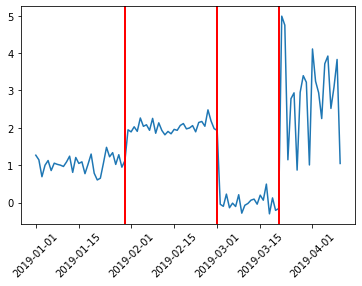

In [24]:
# plot the results
detector = CUSUMDetector(multi_cp_ts) # we are not really using this detector
detector.detector() # this call to detector is not being used for anything

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

## **1.2 BOCPDetector**

Bayesian Online Change Point Detection (BOCPD) is a method for detecting sudden changes in a time series that persist over time. Compared to other changepoint detection methods, this method has some unique features:

* This is an online model. As new data arrives, it revises its predictions. It only needs to look at few steps ahead(specified by the user) to detect, and does not need the entire time series apriori.
* Since this is a Bayesian model, the user can specify their prior belief about the probability of a changepoint, as well as the parameters of the underlying model governing the time series.
This faithfully implements the algorithm in Adams & McKay, 2007. "Bayesian Online Changepoint Detection" (https://arxiv.org/abs/0710.3742).

The basic idea is to see whether the new values are improbable, when compared to a Bayesian predictive model, built from the previous observations.

There are two different classes the user needs to specify. The first is a changepoint detection class, and the second one is the underlying predictive model(UPM). The UPM specifies the generative model, from which successive points in the time series are generated from.

For the changepoint detection model, the user needs to specify:

* The data, which is a univariate time series
* the lag, which specifies how many steps to look ahead to find the changepoint
For the underlying predictive model, currently we only support a Normal distribution with unknown mean, known variance. We will add more distributions in the future. For the UPM, the user needs to specify:

* whether to use empirical prior, derived from the data
* If not using empirical prior, user needs to specify the mean and precision of the prior distribution of the mean, as well the known precision. The model is formulated in terms of precision (which is the inverse of variance) for convenience

The full set of parameters for the `detector` method in `BOCPDetector`, all of which are optional and have default values, are as follows: 

* **model**: This specifies the probabilistic model, that generates the data within each segment. The user can input several model types depending on the behavior of the time series. Currently, allowed models are:
    * NORMAL_KNOWN_MODEL: Normal model with variance known. Use this to find level shifts in normally distributed data.
    * TREND_CHANGE_MODEL : This model assumes each segment is generated from ordinary linear regression. Use this model to understand changes in slope, or trend in time series.
    * POISSON_PROCESS_MODEL: This assumes a Poisson generative model. Use this for count data, where most of the values are close to zero.

* **model_parameters**: Model Parameters correspond to specific parameters for a specific model. They are defined in the NormalKnownParameters, TrendChangeParameters, PoissonModelParameters classes.

* **lag**: integer referring to the lag in reporting the changepoint. We report the changepoint after seeing "lag" number of data points. Higher lag gives greater certainty that this is indeed a changepoint. Lower lag will detect the changepoint faster. This is the trade-off.

* **changepoint_prior**: This is a Bayesian algorithm. Hence, this parameter specifies the prior belief on the probability that a given point is a changepoint. For example, if you believe 10% of your data will be a changepoint, you can set this to 0.1.

* **threshold**: We report the probability of observing the changepoint at each instant. The actual changepoints are obtained by denoting the points above this threshold to be a changepoint.

* **debug**: This surfaces additional information, such as the plots of predicted means and variances, which allows the user to see debug why changepoints were not properly detected.

### Basic Usage
Here we show the basic usage of `BOCPDetector` to detect mean shift.

In [16]:
# import packages
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# synthesize data with simulation
def make_ts():
    np.random.seed(seed=100)# constants
    sigma = 1
    t_start = 0
    t_end = 450#calculation
    num_points = t_end - t_start
    y_val = np.random.normal(loc=1.35, scale=0.05, size=num_points)# make changepoints
    y_val[100:200] = y_val[100:200] - 0.2
    y_val[350:450] = y_val[350:450] - 0.15
    df = pd.DataFrame({'time': pd.date_range('2020-01-01', periods=num_points, freq='H'), 'value': y_val })

    return df
df_bocpd = make_ts()

ModuleNotFoundError: No module named 'ax'

In [ ]:
# use the same data above
tsd = TimeSeriesData(df_bocpd)
detector = BOCPDetector(tsd)
changepoints = detector.detector()

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

### Interpret the results

In [ ]:
cp, meta = changepoints[0]
cp

The BOCPDMetadata tells you the detector type, model type and the name of the time series

In [ ]:
meta.__dict__

## **1.3 RobustStatDetector**

`RobustStatDetector` is also a method to detect mean shift. It first smooths the data using moving average and takes the diff of the time series and calculate z-score on it. Based on the p-value on each data point, it will flag the ones with p-value smaller than the threshold.

The full set of parameters for the `detector` method in `RobustStatDetector`, all of which are optional and have default values, are as follows: 
* **p_value_cutoff**: float, the p-value threshold to flag the change point; 
* **smoothing_window_size**: int, the length of the smoothing window;
* **comparison_window**: int, the step of the diff function, i.e. how many data points you want the algorithm look back to make the comparison.

### Baisc Usage

In [ ]:
# import package
from kats.detectors.robust_stat_detection import RobustStatDetector

tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = RobustStatDetector(tsd)
changepoints = detector.detector()

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

### Multiple Changepoints
The `RobustStatDetector` can detect multiple change points in one time series by one run. But one cautious here is that the algorithm will use the full time series to compute the z-score, which means it might affect the results negatively, e.g. it might not be able to detect a smaller change when there is a bigger change in the time series.

In [ ]:
tsd = TimeSeriesData(df_bocpd)
detector = RobustStatDetector(tsd)
changepoints = detector.detector(p_value_cutoff = 5e-3, comparison_window=2)
detector.plot(changepoints)

In [ ]:
tsd = TimeSeriesData(df_multi_cps)
detector = RobustStatDetector(tsd)
# even setting the p_value to be 0.1 it cannot detect the first change point, while there are already many FPs in the results
changepoints = detector.detector(p_value_cutoff = 1e-1, comparison_window=2)

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

To avoid this we can again use the same way in CUSUMDetector to detect multiple change points by cutting the long time sereis into several different shorter sections.

# 2. Outlier Detection
Outliers in Time Series can cause a lot of issues in downstream processing. Therefore, removing outliers is important in any time series analysis. In Kats, we have three algorithms detecting outliers, one for univariate time series, one for multi-variate time series and one for detecting irregular daily patterns.

## **2.1 OutlierDetector**
We provide the `OutlierDetector` module to detect outliers in time series. Since outliers can cause so many problems in downstream processing, it is important to be able to detect them. `OutlierDetector` also provides functionality to handle or remove outliers once they are found.

Our outlier detection algorithm works as follows:
* We do a [seasonal decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) of the input time series, with additive or multiplicative decomposition as specified (default is additive)
* We generate a residual time series by either removing only trend or both trend and seasonality if the seasonality is strong.
* We detect points in the residual which are outside 3 times the inter quartile range. This multiplier can be tuned using the `iqr_mult` parameter in `OutlierDetector`.

Here are the parameters when initializing `OutlierDetector`:
* **data**: `TimeSeriesData` object with the time series
* **decomp**: `additive` or 'multiplicative' (default is additive)
* **iqr_mult**: `float`, multiplier on inter quartile range is used to classify outliers (default is 3)

### Basic usage

In [ ]:
from kats.detectors.outlier import OutlierDetector
# inject trend and outlier to the seasonality data
df_outlier = df_seasonality.copy()
df_outlier.seasonality = df_outlier.seasonality + np.linspace(0, 20, 72)
df_outlier.loc[30, 'seasonality'] = df_outlier.seasonality.iloc[30] * 2.5

In [ ]:
tsd = TimeSeriesData(df_outlier)
detector = OutlierDetector(tsd, decomp='additive', iqr_mult=3.0)
detector.detector()
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(tsd.time, tsd.value)
# detector.outliers[0] includes all the outlier it detected
for i in detector.outliers[0]:
    dt = datetime.strftime(i, "%Y-%m-%d")
    ax.axvline(i, linewidth=3, linestyle = '--', color='red', alpha = 0.2)

## **2.2 MultivariateAnomalyDetector**
This anomaly detection method is useful to detect anomalies across multiple time series. Anomalies are detected based on deviations from the predicted steady state behavior. The steady state behavior of a system of metrics is predicted by modeling the linear interdependencies between time-series using a VAR model. This approach is especially suited for detecting multivariate anomalies - small anomalies but persistent across a large number of time series.

In addition to identifying an anomalous event, this method has useful utilities to flag specific time series that were affected for a high level root cause analysis. For more details about the approach, please refer to this note.

### Parameters when initial the detector
* **data**: TimeSeriesData - Note that data should be deseasonalized and detrended prior to detection
* **params**: `VARParams` class initiated with appropriate parameters for the VAR model training
* **training_days**: Initial number of days (can be a fraction) to use for training the model. As a result, the first selected number of data points will be excluded from the results.

### VARParams
* **maxlags**: Maximum number of lags to check for order selection, defaults to 12 * (nobs/100.)**(1./4)
* **method**: Estimation method to use, defaults to OLS
* **ic**: Information criterion to use for VAR order selection, defaults to None
* **trend**: 
    * “c” - add constant (Default), 
    * “ct” - constant and trend, 
    * “ctt” - constant, linear and quadratic trend,  
    * “n”/“nc” - no constant, no trend

### Basic usage

In [ ]:
from kats.detectors.outlier import MultivariateAnomalyDetector, MultivariateAnomalyDetectorType
from kats.models.var import VARParams
from kats.models.bayesian_var import BayesianVARParams
import statsmodels.api as sm
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
import statsmodels.tsa.vector_ar.util as util

In [ ]:
# Simulating VAR(2) process by fitting VAR(2) model to macroeconomic data
# load macroeconomic data and preprocess (make it stationary)
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str) # prepare the dates index
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv','realgovt', 'realdpi','cpi', 'm1','unemp','pop']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

# fit VAR(2) model and get coeffs and residual covariance of VAR(2) model
model = VAR(data)
results = model.fit(2)

# simulate VAR(2) data from model parameters estimated above
def simulate_var(results, steps=None, offset=None, seed=None):
    steps_ = None
    if offset is None:
        offset = results.intercept

    y = util.varsim(results.coefs, offset, results.sigma_u, steps=steps, seed=seed)
    return y

y = simulate_var(results, steps=1000, seed=42)
df = pd.DataFrame(y.copy())

In [ ]:
# Add events
# Add offsets to make it easy to see metrics
i=0
for col in df.columns:
    df[col]= df[col]+col/10
    i+=1

# Add spikes to a 3 time series
affected_columns = [0, 5, 6]
for col in affected_columns:
    df.loc[900:910, col]= 1.1* np.percentile(df[col], 75)
df = df+1

# Add level shift to 2 metrics
affected_columns = [1,3]
for col in affected_columns:
    df.loc[600:, col]= df.loc[600:, col] - np.abs(df[col].mean()-1.1* np.percentile(df[col], 60))
df = df+1

df['time'] = list(pd.date_range(end='2020-02-01', periods=df.shape[0]))


In [ ]:
# plot data
fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=1)
df.set_index('time').plot(ax=ax)
plt.show()

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.basicConfig(level=logging.ERROR)

TSData_multi = TimeSeriesData(df)

params = VARParams(maxlags=2)
d = MultivariateAnomalyDetector(TSData_multi, params, training_days=500)
anomaly_score_df = d.detector()
d.plot()

In [ ]:
anomaly_score_df.head()

In [ ]:
# get anomalies by setting desired segnificance level (alpha)
alpha = 0.05
anomalies = d.get_anomaly_timepoints(alpha)
anomalies

In [ ]:
# top_k metrics affected each instant
for a in anomalies:
    print(d.get_anomalous_metrics(a, top_k=2))

### Bayesian VAR

In [ ]:
params = BayesianVARParams(p=2)
d = MultivariateAnomalyDetector(
    TSData_multi, 
    params, 
    training_days=500, 
    model_type=MultivariateAnomalyDetectorType.BAYESIAN_VAR)
anomaly_score_df = d.detector()
d.plot()

In [ ]:
logging.basicConfig(level=logging.INFO)

## **2.3 HourlyRatioDetector**

We observe that for some hourly-level time series related to user behavior (e.g., ALM), there may exist some intra-day irregular pattern (e.g., a time series usually achieves its maximum at 8 a.m., while it achieves its maximum at 10 a.m. on some days) and these days are strong indicators for holidays and big events. The HourlyRatioDetector is designed to detect those irregular patterns. The detailed methodology can be found at https://fb.workplace.com/notes/yang-yu/detecting-abnormal-intra-day-fb-alm/136760347595586/.

Here are the parameters when initializing `OutlierDetector`:
* **data**: TimeSeriesData, the data to be examed. It should have hour-level granularity.
* **freq**: Optional\[str], the data frequency (following the naming conventions of pandas). This will be inferred if it is not specified by user. Should be at least of hourly granularity.Common frequency expressions:
    * 'H': hourly frequency
    * 'T': minutely frequency
    * 'S': secondly frequency
* **aggregate**: Optional\[str], aggreate method (for data with finer granularity than hourly-level)

### Basic usage
In this notebook, we use the ALM data of US in 2007 as an example.

In [ ]:
# we need a data to demo this detector
# TODO

# 3. Trend detection
Trend detection tries to identify significant and prolonged changes in a time series. Similar with change point detection, trend detection also looks for changes. But it is different to change point detection in:
1. Trend detection doesn't look for change point, it is an analysis that looks for the existence of gradual departure of data from its past;
2. Trend detection detects long-term changed, like a slow drift, while change point is trying to detect short-term changed, like a step change;


These are the parameters to use when initializing `MKDetector`:
* **data**: TimeSeriesData, this is time series data at one-day granularity. This time series can be either univariate or multivariate. We require more than training_days points in each time series.
* **threshold**: float, threshold for trend intensity; higher threshold gives trend with high intensity (0.8 by default)
* **alpha**: float, significance level (0.05 by default)s
* **multivariate**: bool, whether the input time series is multivariate

The full set of parameters for the `detector` method in `MKDetector`, all of which are optional and have default values, are as follows: 
* **window_size**: int, the number of look back days for checking trend persistence (20 days by default)
* **training_days**: int, the number of days for time series smoothing; should be greater or equal to window_size (None by default). If training_days is None, we will perform trend detection on the whole time series; otherwise, we will perform trend detection only for the anchor point using the previous training_days data.

* **direction**: string, the direction of the trend to be detected, choose from {"down", "up", "both"}  ("both" by default)

* **freq**: str, the type of seasonality shown in the time series, choose from {'weekly','monthly','yearly'} (None by default)

### Basic usage

In [17]:
# synthesize data with simulation
from scipy.special import expit
def gen_ts(
    initial=10000.0,
    trend=40.0,
    trend_change=-60.0,
    seasonality=0.07,  # multiplicative seasonality
    noise=0.005,  # multiplicative cumulative noise
    n_days=365,
    t_change=250,
    change_smoothness=5.0,
):
    """Generate a sample time series with a trend change, noise, and seasonality"""
    ix = np.arange(n_days)
    data = (
        (
            initial
            + trend * ix
            + trend_change * (ix - t_change) * expit((ix - t_change))
        )
        * (1 - seasonality * (ix % 7 >=5))  # Subtract for saturday and sunday
        * np.cumprod(1 + noise * np.random.randn(n_days)))
    
    t = pd.date_range(start='2020-01-01', periods=n_days, freq='1D')
    return pd.DataFrame({"time":t, "value": data})
tsd = TimeSeriesData(gen_ts())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


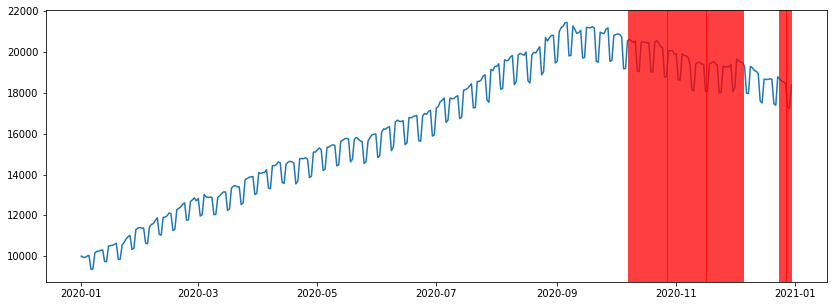

In [18]:
from kats.detectors.trend_mk import MKDetector

detector = MKDetector(data=tsd, threshold=.8)
# run detector
detected_time_points = detector.detector(direction='down', window_size=20, freq='weekly')
# plot the results
detector.plot(detected_time_points)

### Interpret the results
The detector method returns `List[Tuple[TimeSeriesChangePoint, MKMetadata]]`

In [ ]:
cp, meta = detected_time_points[0]
cp

### Multivariate 
In the case of multivariate as input, the algorithm performs the Multivariate Mann-Kendall (MK) test proposed by R. M. Hirsch and J. R. Slack (1984).

# we need a data to demo this detector